In [ ]:
import pandas as pd
import numpy as np

import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn import preprocessing
from sklearn.cluster import KMeans
from  sklearn.metrics import silhouette_score

from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.holtwinters import SimpleExpSmoothing, Holt
from statsmodels.tsa.arima.model import ARIMA
from pandas.plotting import autocorrelation_plot

import warnings
warnings.filterwarnings('ignore')

baca data

In [ ]:
df_customer = pd.read_csv(r'/content/Case Study - Customer.csv', delimiter=';')
df_product = pd.read_csv(r'/content/Case Study - Product.csv', delimiter=';')
df_store = pd.read_csv(r'/content/Case Study - Store.csv', delimiter=';')
df_transaction = pd.read_csv(r'/content/Case Study - Transaction.csv', delimiter=';')


In [ ]:
df_customer.shape, df_product.shape, df_store.shape, df_transaction.shape

((447, 5), (10, 3), (14, 6), (5020, 8))

##data cleansing

In [ ]:
df_customer.head()

,CustomerID,Age,Gender,Marital Status,Income
0,1,55,1,Married,"5,12"
1,2,60,1,Married,"6,23"
2,3,32,1,Married,"9,17"
3,4,31,1,Married,"4,87"
4,5,58,1,Married,"3,57"


In [ ]:
df_customer.duplicated().sum()

0

In [ ]:
df_customer.isnull().sum()

CustomerID        0
Age               0
Gender            0
Marital Status    3
Income            0
dtype: int64

In [ ]:
df_customer[df_customer['Marital Status'].isnull()]

,CustomerID,Age,Gender,Marital Status,Income
9,10,34,1,NaN,4
415,416,27,1,NaN,"3,43"
442,443,33,1,NaN,"9,28"


In [ ]:
df_merge[df_merge['Marital Status'].isnull()].shape

(44, 18)

In [ ]:
df_product.head()

,ProductID,Product Name,Price
0,P1,Choco Bar,8800
1,P2,Ginger Candy,3200
2,P3,Crackers,7500
3,P4,Potato Chip,12000
4,P5,Thai Tea,4200


In [ ]:
df_store.head()

,StoreID,StoreName,GroupStore,Type,Latitude,Longitude
0,1,Prima Tendean,Prima,Modern Trade,"-6,2","106,816666"
1,2,Prima Kelapa Dua,Prima,Modern Trade,"-6,914864","107,608238"
2,3,Prima Kota,Prima,Modern Trade,"-7,797068","110,370529"
3,4,Gita Ginara,Gita,General Trade,"-6,966667","110,416664"
4,5,Bonafid,Gita,General Trade,"-7,250445","112,768845"


In [ ]:
df_transaction.head()

,TransactionID,CustomerID,Date,ProductID,Price,Qty,TotalAmount,StoreID
0,TR11369,328,01/01/2022,P3,7500,4,30000,12
1,TR16356,165,01/01/2022,P9,10000,7,70000,1
2,TR1984,183,01/01/2022,P1,8800,4,35200,4
3,TR35256,160,01/01/2022,P1,8800,7,61600,4
4,TR41231,386,01/01/2022,P9,10000,1,10000,4


In [ ]:
df_customer.dtypes, df_store.dtypes, df_transaction.dtypes

(CustomerID         int64
 Age                int64
 Gender             int64
 Marital Status    object
 Income            object
 dtype: object,
 StoreID        int64
 StoreName     object
 GroupStore    object
 Type          object
 Latitude      object
 Longitude     object
 dtype: object,
 TransactionID    object
 CustomerID        int64
 Date             object
 ProductID        object
 Price             int64
 Qty               int64
 TotalAmount       int64
 StoreID           int64
 dtype: object)

In [ ]:
#data cleansing df_customer
df_customer['Income'] = df_customer['Income'].replace('[,]','.',regex=True).astype('float')

In [ ]:
#data cleansing df_store
df_store['Latitude'] = df_store['Latitude'].replace('[,]','.',regex=True).astype('float')
df_store['Longitude'] = df_store['Longitude'].replace('[,]','.',regex=True).astype('float')

In [ ]:
#data cleansing df_transaction
df_transaction['Date'] = pd.to_datetime(df_transaction['Date'])

In [ ]:
df_transaction['TransactionID'].value_counts()

TR71313    3
TR42197    2
TR90402    2
TR74019    2
TR49649    2
          ..
TR29792    1
TR23081    1
TR1691     1
TR98388    1
TR85684    1
Name: TransactionID, Length: 4908, dtype: int64

In [ ]:
df_transaction[df_transaction['TransactionID'] == 'TR71313']

,TransactionID,CustomerID,Date,ProductID,Price,Qty,TotalAmount,StoreID
1982,TR71313,117,2022-05-21,P1,8800,10,88000,8
3336,TR71313,401,2022-08-30,P3,7500,6,45000,11
3722,TR71313,370,2022-09-26,P3,7500,2,15000,3


##gabungkan semua data

In [ ]:
df_merge = pd.merge(df_transaction, df_customer, on=['CustomerID'])
df_merge = pd.merge(df_merge, df_product.drop(columns=['Price']), on=['ProductID'])
df_merge = pd.merge(df_merge, df_store, on=['StoreID'])

In [ ]:
df_merge.head()

,TransactionID,CustomerID,Date,ProductID,Price,Qty,TotalAmount,StoreID,Age,Gender,Marital Status,Income,Product Name,StoreName,GroupStore,Type,Latitude,Longitude
0,TR11369,328,2022-01-01,P3,7500,4,30000,12,36,0,Married,10.53,Crackers,Prestasi Utama,Prestasi,General Trade,-2.990934,104.756554
1,TR89318,183,2022-07-17,P3,7500,1,7500,12,27,1,Single,0.18,Crackers,Prestasi Utama,Prestasi,General Trade,-2.990934,104.756554
2,TR9106,123,2022-09-26,P3,7500,4,30000,12,34,0,Married,4.36,Crackers,Prestasi Utama,Prestasi,General Trade,-2.990934,104.756554
3,TR4331,335,2022-08-01,P3,7500,3,22500,12,29,1,Single,4.74,Crackers,Prestasi Utama,Prestasi,General Trade,-2.990934,104.756554
4,TR6445,181,2022-10-01,P3,7500,4,30000,12,33,1,Married,9.94,Crackers,Prestasi Utama,Prestasi,General Trade,-2.990934,104.756554


##model machine learning regresi (time series)

In [ ]:
df_regresi = df_merge.groupby(['Date']).agg({
    'Qty' : 'sum'
}).reset_index()

In [ ]:
df_regresi

,Date,Qty
0,2022-01-01,49
1,2022-01-02,50
2,2022-01-03,76
3,2022-01-04,98
4,2022-01-05,67
...,...,...
360,2022-12-27,70
361,2022-12-28,68
362,2022-12-29,42
363,2022-12-30,44


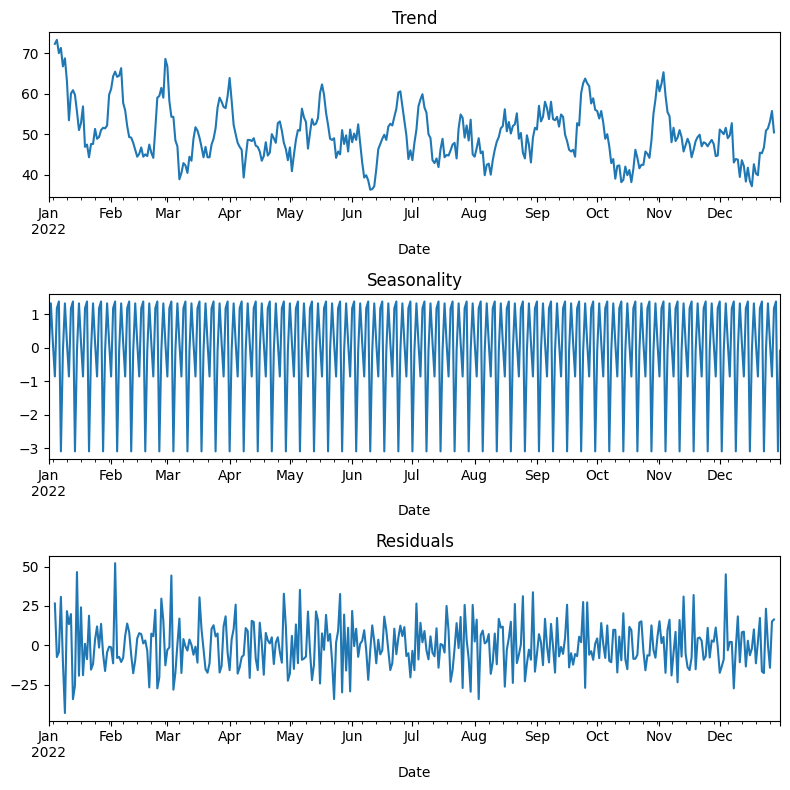

In [ ]:
decomposed = seasonal_decompose(df_regresi.set_index('Date'))

plt.figure(figsize=(8, 8))

plt.subplot(311)
decomposed.trend.plot(ax=plt.gca())
plt.title('Trend')
plt.subplot(312)
decomposed.seasonal.plot(ax=plt.gca())
plt.title('Seasonality')
plt.subplot(313)
decomposed.resid.plot(ax=plt.gca())
plt.title('Residuals')

plt.tight_layout()

## uji stasioner

In [ ]:
from statsmodels.tsa.stattools import adfuller
result = adfuller(df_regresi['Qty'])
print('ADF Statisctic: %f' % result[0])
print('p-value: %f' % result[1])
print('Critical Values:')
for key, value in result[4].items():
  print('\t%s: %.3f' % (key, value))

ADF Statisctic: -19.018783
p-value: 0.000000
Critical Values:
	1%: -3.448
	5%: -2.870
	10%: -2.571


## check stationary data

In [ ]:
cut_off = round(df_regresi.shape[0] * 0.8)
df_train = df_regresi[:cut_off]
df_test = df_regresi[cut_off:].reset_index(drop=True)
df_train.shape, df_test.shape

((292, 2), (73, 2))

In [ ]:
df_train

,Date,Qty
0,2022-01-01,49
1,2022-01-02,50
2,2022-01-03,76
3,2022-01-04,98
4,2022-01-05,67
...,...,...
287,2022-10-15,33
288,2022-10-16,26
289,2022-10-17,53
290,2022-10-18,47


In [ ]:
df_test

,Date,Qty
0,2022-10-20,39
1,2022-10-21,35
2,2022-10-22,56
3,2022-10-23,59
4,2022-10-24,39
...,...,...
68,2022-12-27,70
69,2022-12-28,68
70,2022-12-29,42
71,2022-12-30,44


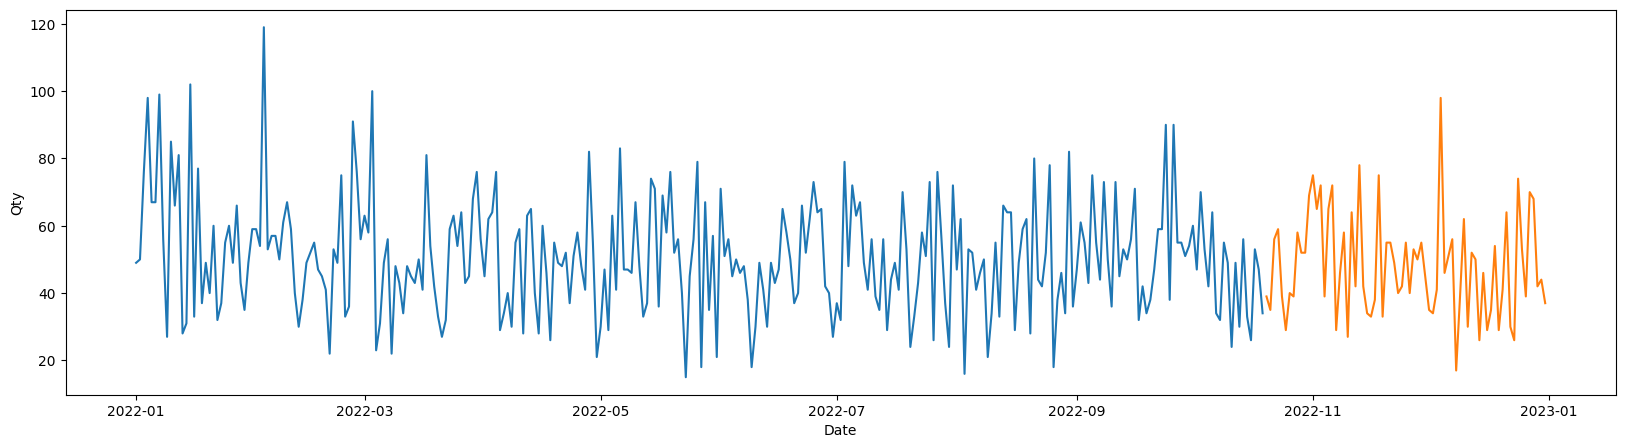

In [ ]:
plt.figure(figsize=(20,5))
sns.lineplot(data=df_train, x=df_train['Date'], y=df_train['Qty']);
sns.lineplot(data=df_test, x=df_test['Date'], y=df_test['Qty']);

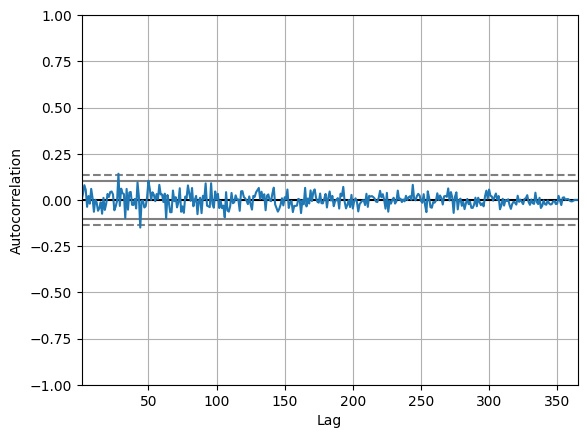

In [ ]:
autocorrelation_plot(df_regresi['Qty']);

In [ ]:
def rmse(y_actual, y_pred):
  """
  function to calculate RMSE
  """

  print(f'RMSE Value {mean_squared_error(y_actual, y_pred)**0.5}')

def eval(y_actual, y_pred):
  """
  function to eval machine learning modelling
  """
  rmse(y_actual, y_pred)
  print(f'MAE value {mean_absolute_error(y_actual, y_pred)}')

RMSE Value 15.47240015957555
MAE value 12.357079716384185


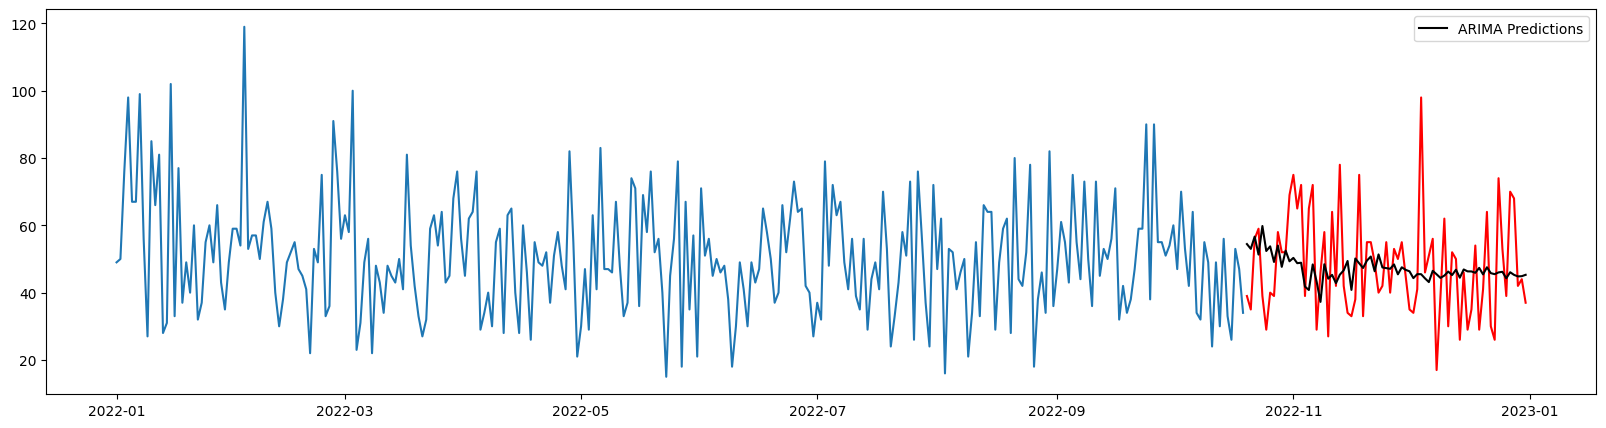

In [ ]:
##ARIMA
df_train = df_train.set_index('Date')
df_test = df_test.set_index('Date')

y = df_train['Qty']

ARIMAmodel = ARIMA(y, order = (40, 2, 1))
ARIMAmodel = ARIMAmodel.fit()

y_pred = ARIMAmodel.get_forecast(len(df_test))

y_pred_df = y_pred.conf_int()
y_pred_df['predictions'] = ARIMAmodel.predict(start =y_pred_df.index[0], end =y_pred_df.index[-1])
y_pred_df.index = df_test.index
y_pred_out = y_pred_df['predictions']
eval(df_test['Qty'], y_pred_out)

plt.figure(figsize=(20,5))
plt.plot(df_train['Qty'])
plt.plot(df_test['Qty'], color='red')
plt.plot(y_pred_out, color='black', label = 'ARIMA Predictions')
plt.legend()

##clustering

In [ ]:
df_merge.head()

,TransactionID,CustomerID,Date,ProductID,Price,Qty,TotalAmount,StoreID,Age,Gender,Marital Status,Income,Product Name,StoreName,GroupStore,Type,Latitude,Longitude
0,TR11369,328,2022-01-01,P3,7500,4,30000,12,36,0,Married,10.53,Crackers,Prestasi Utama,Prestasi,General Trade,-2.990934,104.756554
1,TR89318,183,2022-07-17,P3,7500,1,7500,12,27,1,Single,0.18,Crackers,Prestasi Utama,Prestasi,General Trade,-2.990934,104.756554
2,TR9106,123,2022-09-26,P3,7500,4,30000,12,34,0,Married,4.36,Crackers,Prestasi Utama,Prestasi,General Trade,-2.990934,104.756554
3,TR4331,335,2022-08-01,P3,7500,3,22500,12,29,1,Single,4.74,Crackers,Prestasi Utama,Prestasi,General Trade,-2.990934,104.756554
4,TR6445,181,2022-10-01,P3,7500,4,30000,12,33,1,Married,9.94,Crackers,Prestasi Utama,Prestasi,General Trade,-2.990934,104.756554


In [ ]:
#identifikasi kolom yg redundant/corelasi tinggi
df_merge.corr()

,CustomerID,Price,Qty,TotalAmount,StoreID,Age,Gender,Income,Latitude,Longitude
CustomerID,1.000000,-0.016423,-0.009755,-0.024915,0.004129,-0.025952,-0.009947,0.005783,0.002278,-0.003122
Price,-0.016423,1.000000,-0.353640,0.440632,-0.032863,0.014693,0.010705,0.001196,-0.029008,0.018652
Qty,-0.009755,-0.353640,1.000000,0.621129,0.014365,-0.027768,-0.010542,-0.028425,-0.004170,0.004807
TotalAmount,-0.024915,0.440632,0.621129,1.000000,-0.010722,-0.016900,-0.008774,-0.025350,-0.029938,0.025437
StoreID,0.004129,-0.032863,0.014365,-0.010722,1.000000,-0.003872,-0.000189,0.001613,0.471852,-0.094943
Age,-0.025952,0.014693,-0.027768,-0.016900,-0.003872,1.000000,-0.033183,0.486692,0.009266,0.015951
Gender,-0.009947,0.010705,-0.010542,-0.008774,-0.000189,-0.033183,1.000000,-0.071443,-0.006051,-0.001183
Income,0.005783,0.001196,-0.028425,-0.025350,0.001613,0.486692,-0.071443,1.000000,0.015518,0.004385
Latitude,0.002278,-0.029008,-0.004170,-0.029938,0.471852,0.009266,-0.006051,0.015518,1.000000,-0.395995
Longitude,-0.003122,0.018652,0.004807,0.025437,-0.094943,0.015951,-0.001183,0.004385,-0.395995,1.000000


In [ ]:
df_cluster = df_merge.groupby(['CustomerID']).agg({
    'TransactionID' : 'count',
    'Qty' : 'sum',
    'Age' : 'first'
}).reset_index().rename(columns={
    'TransactionID' : 'count_transaction',
    'Qty' : 'total_qty'
})

In [ ]:
df_cluster.head()

,CustomerID,count_transaction,total_qty,Age
0,1,17,60,55
1,2,13,57,60
2,3,15,56,32
3,4,10,46,31
4,5,7,27,58


In [ ]:
data_cluster = df_cluster.drop(columns={'CustomerID'})

data_cluster_normalize = preprocessing.normalize(data_cluster)

In [ ]:
data_cluster_normalize

array([[0.20444864, 0.72158345, 0.66145149],
       [0.15518033, 0.68040606, 0.71621691],
       [0.22651995, 0.84567449, 0.48324256],
       ...,
       [0.20717044, 0.78264389, 0.58698292],
       [0.15351993, 0.58616699, 0.79551234],
       [0.18668837, 0.60314704, 0.77547476]])

In [ ]:
K = range(2, 8)
fits = []
score = []

for k in K:
  model = KMeans(n_clusters = k, random_state = 0, n_init='auto').fit(data_cluster_normalize)

  fits.append(model)

  score.append(silhouette_score(data_cluster_normalize, model.labels_, metric='euclidean'))

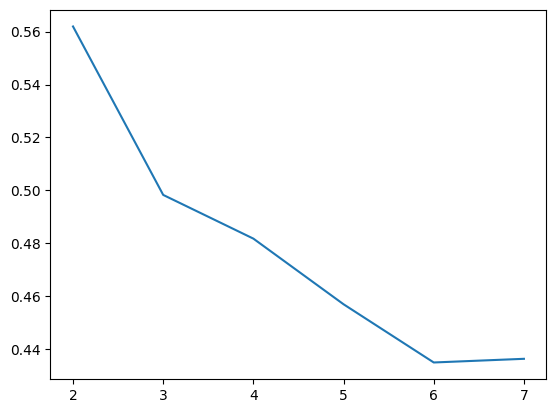

In [ ]:
#choose 4 cluster
sns.lineplot(x = K, y = score);

In [ ]:
fits[2]

KMeans(n_clusters=4, n_init='auto', random_state=0)

In [ ]:
df_cluster['cluster_label'] = fits[2].labels_

In [ ]:
df_cluster

,CustomerID,count_transaction,total_qty,Age,cluster_label
0,1,17,60,55,3
1,2,13,57,60,2
2,3,15,56,32,1
3,4,10,46,31,3
4,5,7,27,58,0
...,...,...,...,...,...
442,443,16,59,33,1
443,444,18,62,53,3
444,445,18,68,51,3
445,446,11,42,57,2


In [ ]:
df_cluster.groupby(['cluster_label']).agg({
    'CustomerID' : 'count',
    'count_transaction' : 'mean',
    'total_qty' : 'mean',
    'Age' : 'mean'
})

,CustomerID,count_transaction,total_qty,Age
cluster_label,,,,
0,105,8.371429,28.390476,49.857143
1,72,13.750000,53.166667,24.750000
2,140,11.250000,39.564286,44.800000
3,130,12.123077,45.753846,34.569231


In [ ]:
cluster 0 --> transaksi terkecil, qty terkecil (rata-rata umur tertua)
cluster 1 --> transaksi terbesar, qty terbesar (rata-rata umur termuda)
cluster 2 --> transaksi sedang, qty sedang
cluster 3 --> transaksi sedang, qty sedang

##bussines rekomendasi:
1.